In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer 

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, roc_curve, auc, make_scorer, accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import shuffle
from sklearn import svm

import sentencepiece as spm
from joblib import dump

In [2]:
df = pd.read_csv('/Users/alenjose/Desktop/data/project_data/training_data/cleaned_model_data.csv',index_col=0)
df.head()

,target,tweet_text,original_text_length,current_tweet_len
0,0,awww that bummer you shoulda got david carr of...,115,65
1,0,is upset that he can update his facebook by te...,111,101
2,0,dived many times for the ball managed to save ...,89,71
3,0,my whole body feels itchy and like its on fire,47,46
4,0,no it not behaving at all mad why am here beca...,111,76


In [3]:
print('string maximum length: ',df.tweet_text.str.len().sort_values(ascending=False).head(1))

538615    137
Name: tweet_text, dtype: int64


In [4]:
# 80 - 20 split (training and testing)
x_train, x_test_temp, y_train, y_test_temp = train_test_split(df['tweet_text'], df['target'], test_size=0.2, random_state=42)

# 50 - 50 split on the temp data 
x_val, x_test, y_val, y_test = train_test_split(x_test_temp, y_test_temp, test_size=0.5, random_state=42)

## Stochastic Gradient Descent Classifier : 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

### Parameter Tuning (Full dataset)

In [69]:
# range of features and param grid
feature_range = [5000, 10000, 20000, 50000, 100000]
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
#   l1 - sets less imp weights to 0; l2 = sum(square of weights) * alpha; elasticnet = combination of l1, l2
    'penalty': ['l2', 'l1', 'elasticnet'], # regularization methods
}

# SGD model (hinge loss function makes it equivalent to a linear SVM)
svm_model = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)

# store val acc and optimal params
val_accs = {}
best_params = {}

for max_features in feature_range:
    print(f"max_features: {max_features}")

    vectorizer = CountVectorizer(max_features=max_features)
    x_train_vect = vectorizer.fit_transform(x_train)
    x_val_vect = vectorizer.transform(x_val)

    grid_search = GridSearchCV(svm_model, param_grid, cv=3, verbose=1)
    grid_search.fit(x_train_vect, y_train)

    best_params[max_features] = grid_search.best_params_
    print(f"Best parameters: {best_params[max_features]}")

    y_val_pred = grid_search.best_estimator_.predict(x_val_vect)

    val_accs[max_features] = accuracy_score(y_val, y_val_pred)
    print(f"Validation accuracy for max_features {max_features}: {val_accs[max_features]}")

max_features: 5000
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'alpha': 0.0001, 'penalty': 'l2'}
Validation accuracy for max_features 5000: 0.7860781303843865
max_features: 10000
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'alpha': 0.0001, 'penalty': 'l2'}
Validation accuracy for max_features 10000: 0.7884214153691927
max_features: 20000
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'alpha': 0.0001, 'penalty': 'l2'}
Validation accuracy for max_features 20000: 0.788446477240688
max_features: 50000
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'alpha': 0.0001, 'penalty': 'l2'}
Validation accuracy for max_features 50000: 0.7886720340841452
max_features: 100000
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'alpha': 0.0001, 'penalty': 'l2'}
Validation accuracy for max_features 100000: 0.7881833275899878


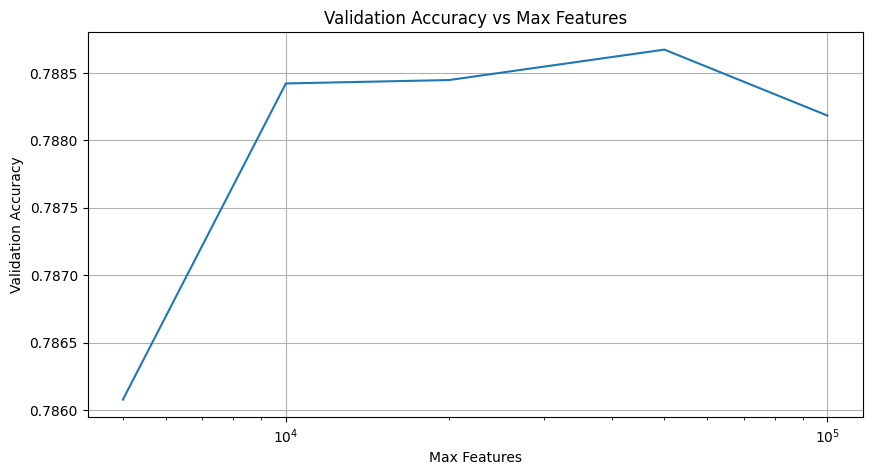

In [70]:
# plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(list(val_accs.keys()), list(val_accs.values()))
plt.xscale('log')
plt.xlabel('Max Features')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Max Features')
plt.grid(True)
plt.show()

In [10]:
vectorizer = CountVectorizer(max_features=50000)
x_train_vect = vectorizer.fit_transform(x_train)
x_val_vect = vectorizer.transform(x_val)

# train model using best parameters
svm_model = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', max_iter=1000, tol=1e-3)
svm_model.fit(x_train_vect, y_train)

# predictions on val
y_val_pred = svm_model.predict(x_val_vect)

# Metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, pos_label=4)
recall = recall_score(y_val, y_val_pred, pos_label=4)
f1 = f1_score(y_val, y_val_pred, pos_label=4)
conf_mat = confusion_matrix(y_val, y_val_pred)
class_rep = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {accuracy}')
print(f'Validation Precision: {precision}')
print(f'Validation Recall: {recall}')
print(f'Validation F1 Score: {f1}')
print(f'Validation Confusion Matrix:\n{conf_mat}')
print(f'Validation Classification Report:\n{class_rep}')

Validation Accuracy: 0.7892108643212932
Validation Precision: 0.776611712012198
Validation Recall: 0.8140725479178373
Validation F1 Score: 0.7949010260130585
Validation Confusion Matrix:
[[60767 18753]
 [14890 65195]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     79520
           4       0.78      0.81      0.79     80085

    accuracy                           0.79    159605
   macro avg       0.79      0.79      0.79    159605
weighted avg       0.79      0.79      0.79    159605



## Multinomial Naive Bayes (full dataset) : 

In [11]:
# range of features
feature_range = [i for i in range(10000,130000,10000)]
validation_accs_nb = []

for max_features in feature_range:
    print(f"\nfeature set_size: {max_features}")
    
    # transform data
    vectorizer = CountVectorizer(max_features=max_features)
    x_train_vect = vectorizer.fit_transform(x_train)
    x_val_vect = vectorizer.transform(x_val)

    # regularisation params for grid search
    param_grid = {'alpha': np.linspace(0.5, 1.5, 6)}

    # GridSearchCV object and fitting model
    grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, verbose=1)
    grid.fit(x_train_vect, y_train)

    # apply best model to predict the val set
    best_nb_model = grid.best_estimator_
    y_val_pred = best_nb_model.predict(x_val_vect)

    # append to acc list
    validation_accs_nb.append(accuracy_score(y_val, y_val_pred))


feature set_size: 10000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 20000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 30000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 40000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 50000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 60000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 70000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 80000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 90000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 100000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 110000
Fitting 5 folds for each of 6 candidates, totalling 30 fits

feature set_size: 120000
Fitting 5 folds for each of 6 candida

In [13]:
print(validation_accs_nb)

[0.7777325271764669, 0.7812161273143072, 0.7824441590175747, 0.7830895022085774, 0.7830957676764513, 0.7831333604836941, 0.7832022806303061, 0.783170953290937, 0.7831208295479465, 0.7830769712728298, 0.7830957676764513, 0.7830456439334608]


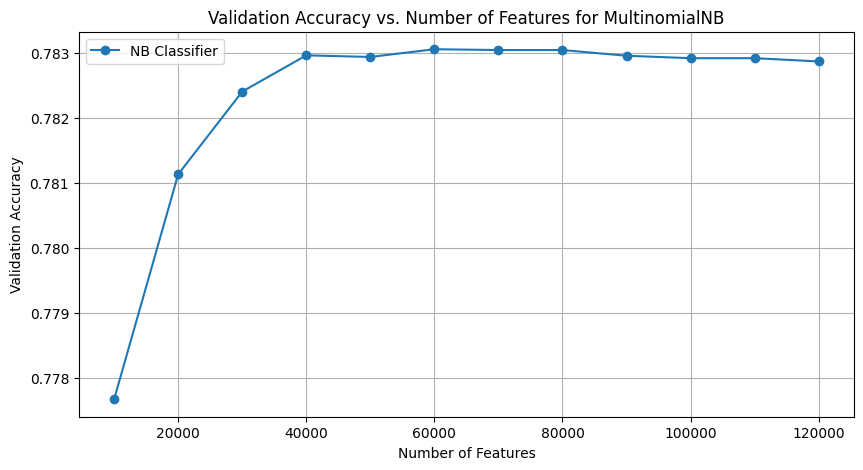

In [72]:
plt.figure(figsize=(10,5))
plt.plot(feature_range, validation_accs_nb, marker='o', label='NB Classifier')

plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Features for MultinomialNB')
plt.grid()
plt.legend()
plt.show()

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

# feature range
for max_features in feature_range:
    
    # pipeline
    text_clf = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=max_features)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ])
    
    # grid search params
    param_grid = {
        'clf__alpha': np.linspace(0.5, 1.5, 6)
    }
    
    # grid search (5 fold cross validation)
    grid = GridSearchCV(text_clf, param_grid, cv=5, verbose=1)
    grid.fit(x_train, y_train)

    # best model
    best_model = grid.best_estimator_
    
    # val
    y_val_pred = best_model.predict(x_val)
    validation_accs_nb.append(accuracy_score(y_val, y_val_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [15]:
print("Best parameters:", grid.best_params_)

Best parameters: {'clf__alpha': 1.5}


In [16]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.288307,0.191689,2.172344,0.042828,0.5,{'clf__alpha': 0.5},0.770967,0.769647,0.770899,0.771068,0.769388,0.770394,0.000722,6
1,15.395811,0.183155,2.167115,0.027403,0.7,{'clf__alpha': 0.7},0.771409,0.769941,0.771487,0.771745,0.769979,0.770912,0.000786,5
2,15.261685,0.112725,2.139511,0.019530,0.9,{'clf__alpha': 0.9},0.771613,0.770321,0.771886,0.772321,0.770606,0.771349,0.000763,4
3,15.418420,0.106582,2.184130,0.030290,1.1,{'clf__alpha': 1.1},0.771910,0.770763,0.772113,0.772701,0.770950,0.771687,0.000729,3
4,15.426648,0.262069,2.184018,0.021701,1.3,{'clf__alpha': 1.3},0.772314,0.771041,0.772411,0.772920,0.771283,0.771994,0.000714,2
5,15.459265,0.375348,2.141161,0.037664,1.5,{'clf__alpha': 1.5},0.772545,0.771272,0.772783,0.773077,0.771534,0.772242,0.000710,1


In [17]:
print("Best score:", grid.best_score_)

Best score: 0.7722419850435557


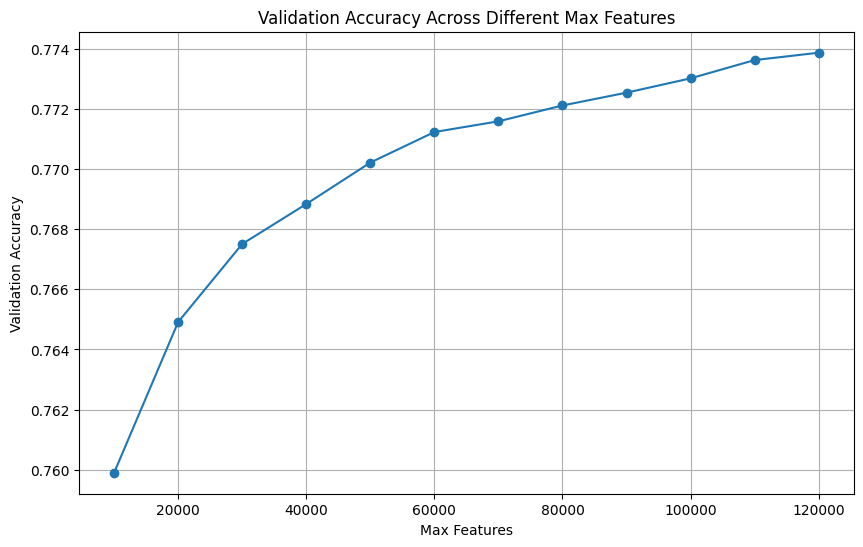

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(feature_range, validation_accs_nb, marker='o', linestyle='-')
plt.xlabel('Max Features')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Across Different Max Features')
plt.grid(True)
plt.show()

In [26]:
validation_accs_nb = []

# pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf', MultinomialNB())
])

# grid search params (more combinations)
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'tfidf__use_idf': [True, False],
    'clf__alpha': np.linspace(0.5, 1.5, 6)
}

# grid Search
grid = GridSearchCV(text_clf, param_grid, cv=5, verbose=1)
grid.fit(x_train, y_train)

# best model
best_model = grid.best_estimator_

# val the model
y_val_pred = best_model.predict(x_val)
validation_accs_nb.append(accuracy_score(y_val, y_val_pred))

pd.DataFrame(grid.cv_results_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_tfidf__use_idf,param_vect__ngram_range,param_vect__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.423377,0.048517,1.255982,0.021007,0.5,True,"(1, 1)",english,"{'clf__alpha': 0.5, 'tfidf__use_idf': True, 'v...",0.757112,0.756983,0.757546,0.758760,0.757338,0.757548,0.000636,48
1,5.728525,0.098250,1.305217,0.008895,0.5,True,"(1, 1)",None,"{'clf__alpha': 0.5, 'tfidf__use_idf': True, 'v...",0.769909,0.770497,0.770551,0.771228,0.771138,0.770665,0.000480,35
2,15.409241,0.243638,2.321030,0.020052,0.5,True,"(1, 2)",english,"{'clf__alpha': 0.5, 'tfidf__use_idf': True, 'v...",0.771029,0.769389,0.770609,0.771393,0.769572,0.770398,0.000792,36
3,19.516893,0.239748,3.346880,0.185002,0.5,True,"(1, 2)",None,"{'clf__alpha': 0.5, 'tfidf__use_idf': True, 'v...",0.800144,0.800645,0.800410,0.801263,0.800069,0.800506,0.000430,9
4,5.388453,0.094731,1.296268,0.056607,0.5,False,"(1, 1)",english,"{'clf__alpha': 0.5, 'tfidf__use_idf': False, '...",0.767630,0.767368,0.767610,0.769270,0.768558,0.768087,0.000718,42
5,5.770725,0.245417,1.310336,0.056462,0.5,False,"(1, 1)",None,"{'clf__alpha': 0.5, 'tfidf__use_idf': False, '...",0.782530,0.783122,0.782467,0.783321,0.782949,0.782878,0.000332,18
6,14.681309,0.131187,2.189738,0.024844,0.5,False,"(1, 2)",english,"{'clf__alpha': 0.5, 'tfidf__use_idf': False, '...",0.777267,0.775697,0.776981,0.777349,0.776566,0.776772,0.000603,24
7,17.930281,0.090035,3.105111,0.111229,0.5,False,"(1, 2)",None,"{'clf__alpha': 0.5, 'tfidf__use_idf': False, '...",0.801593,0.803187,0.802469,0.803535,0.801678,0.802492,0.000780,1
8,5.167087,0.061137,1.218028,0.009461,0.7,True,"(1, 1)",english,"{'clf__alpha': 0.7, 'tfidf__use_idf': True, 'v...",0.758722,0.758436,0.759022,0.760248,0.758744,0.759034,0.000635,47
9,5.669886,0.041748,1.298927,0.023994,0.7,True,"(1, 1)",None,"{'clf__alpha': 0.7, 'tfidf__use_idf': True, 'v...",0.771429,0.771863,0.771788,0.772654,0.772340,0.772015,0.000432,34


In [27]:
print("Best parameters:", grid.best_params_)

Best parameters: {'clf__alpha': 0.5, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}


In [28]:
print("Best parameters:", grid.best_params_) 

Best parameters: {'clf__alpha': 0.5, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}


In [30]:
# Create the pipeline using the best parameters
text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2), stop_words=None, max_features=120000)),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', MultinomialNB(alpha=0.5))
])

text_clf.fit(x_train, y_train)

y_val_pred = text_clf.predict(x_val)

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, pos_label=4)  
recall = recall_score(y_val, y_val_pred, pos_label=4)  
f1 = f1_score(y_val, y_val_pred, pos_label=4)  
conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")

Accuracy: 0.8012969518498794
Precision: 0.8102654231504407
Recall: 0.7886745333083599
F1 Score: 0.7993242046116075
Confusion Matrix: 
[[64730 14790]
 [16924 63161]]


# Random Forest Classifier 

### finding max_feature parameter with 10% DATASET

In [38]:
x = df.tweet_text
y = df.target

# shuffling data (randomizing)
x, y = shuffle(x, y, random_state=42)

# 10% of the data used (lack of computational power)
subset_fraction = 0.1

# num of samples to be included in the subset
subset_size = int(subset_fraction * len(y))

# final subset
x_subset = x[:subset_size]
y_subset = y[:subset_size]

# splitting subset into training, val sets
x_train_subset, x_val_subset, y_train_subset, y_val_subset = train_test_split(x_subset, y_subset, test_size=0.2, random_state=42)

In [24]:
# param grid
param_grid = {
#   num of trees
    'n_estimators': [10, 50, 100, 200],
#   max depth of each tree
    'max_depth': [None, 10, 20, 30],
#   min num of samples needed to split an internal node in each tree.
    'min_samples_split': [2, 5, 10],
#   min number of samples needed to be a leaf node
    'min_samples_leaf': [1, 2, 4]
}

# range of features
feature_range = [i for i in range(10000,130000,10000)]
validation_accs = []

for max_features in feature_range:
    # vectorizer with current # of max_features
    vectorizer = CountVectorizer(max_features=max_features, stop_words=stop_words)

    # transform the data
    x_train_vect = vectorizer.fit_transform(x_train_subset)
    x_val_vect = vectorizer.transform(x_val_subset)

    # randomizedSearchCV
    random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42)

    # fitting model to training data
    random_search.fit(x_train_vect, y_train_subset)

    # display best parameters for current max_features
    print(f"Best parameters for feature set size {max_features}: {random_search.best_params_}")

    # predict on the val data using best model
    y_val_pred = random_search.best_estimator_.predict(x_val_vect)

    # append accuracy
    validation_accs.append(accuracy_score(y_val_subset, y_val_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  32.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  30.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  33.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.0s
[CV] END max_depth=20

[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=  13.1s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   2.0s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   2.1s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   

[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 8.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 8.7min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 8.9min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  26.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  27.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  27.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  12.8s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  12.9s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  13.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10; tot

[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   6.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   6.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   6.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.4min
Best parameters for feature set size 80000: {'n_estimators': 200, 'min_samples_split': 5

[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  27.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  27.1s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  12.9s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  12.9s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  13.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=  26.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total ti

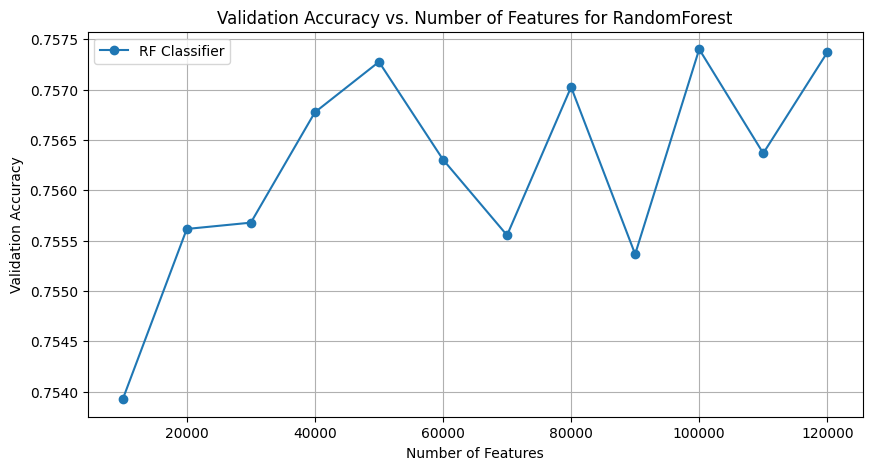

In [25]:
plt.figure(figsize=(10,5))
plt.plot(feature_range, validation_accs, marker='o', label='RF Classifier')

plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Features for RandomForest')
plt.grid()
plt.legend()
plt.show()

In [31]:
# saving results 
df_results = pd.DataFrame({
    'max_features': feature_range,
    'validation_acc':validation_accs
})

df_results.to_csv('/Users/alenjose/Desktop/data/project_data/training_data/random_forest_results.csv',index=False)
df_results.sort_values(by='validation_acc',ascending=False).iloc[:1]

,max_features,validation_acc
9,100000,0.757401


In [48]:
print("Best parameters for feature set size 100000: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}")

Best parameters for feature set size 100000: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


### Fixing max_features as 100,000 and finding optimal hyperparameters by passing more data to the model. 

In [46]:
# 30% of data used (cost of computational needs)
subset_fraction = 0.3

# num of samples to be included in subset
subset_size = int(subset_fraction * len(y))

# final subset
x_subset_30 = x[:subset_size]
y_subset_30 = y[:subset_size]

# splitting subset into training, val sets
x_train_subset, x_val_subset, y_train_subset, y_val_subset = train_test_split(x_subset, y_subset, test_size=0.2, random_state=42)

In [47]:
# parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# range of features
max_features = [100000]

# empty val accuracy list
validation_accs = []

# vectorizer with fixed max_features
vectorizer = CountVectorizer(max_features=max_features, stop_words=stop_words)

# transform data
x_train_vect = vectorizer.fit_transform(x_train_subset)
x_val_vectorized = vectorizer.transform(x_val_subset)

# randomForestClassifier Instance
rf = RandomForestClassifier()

# randomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42)

# fitting model to training data
random_search.fit(X_train_vectorized, y_train_subset)

# display best parameters for current max_features
print(f"Best parameters for feature set size {max_features}: {random_search.best_params_}")

# predict on validation data using best model
y_val_pred = random_search.best_estimator_.predict(x_val_vect)

# calculate val acc
val_acc = accuracy_score(y_val_subset, y_val_pred)

# append accuracy to the list
validation_accs.append(val_acc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 1.2min
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 1.2min
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=38.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=38.3min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=38.6min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.6min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.6min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.6min
[CV] END max_depth=20

In [66]:
print(validation_accs[0]*100,"is the accuracy with parameters : feature set size 100000 ,'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None")

76.2914695654898 is the accuracy with parameters : feature set size 100000 ,'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None


## Training the model based on the parameters acquired

In [31]:
x_train, x_test_temp, y_train, y_test_temp = train_test_split(df['tweet_text'], df['target'], test_size=0.2, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_test_temp, y_test_temp, test_size=0.5, random_state=42) 

**COUNTVECTORIZER**

### without stopwords

In [33]:
max_features = 100000
vectorizer = CountVectorizer(max_features=max_features, stop_words=stop_words)

# transform training data
x_train_vect = vectorizer.fit_transform(x_train)
x_test_vect = vectorizer.transform(x_test)

# rfc with best parameters
rf_sw = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_depth=None)

# fit model to entire training data
rf_sw.fit(x_train_vect, y_train)

# make predictions on test data using best model
y_test_pred = rf_sw.predict(x_test_vect)

# calculate test acc
test_acc = accuracy_score(y_test, y_test_pred)

test_precision = precision_score(y_test, y_test_pred,  pos_label=4)
test_recall = recall_score(y_test, y_test_pred,  pos_label=4)  
test_f1 = f1_score(y_test, y_test_pred,  pos_label=4)  
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics
print(f"Test accuracy: {test_acc}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1 score: {test_f1}")
print(f"Confusion Matrix: \n{conf_matrix}")

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Test accuracy: 0.7728907434557598
Test precision: 0.7755681459702961
Test recall: 0.769008445417579
Test F1 score: 0.7722743664166257
Confusion Matrix: 
[[61895 17786]
 [18462 61463]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77     79681
           4       0.78      0.77      0.77     79925

    accuracy                           0.77    159606
   macro avg       0.77      0.77      0.77    159606
weighted avg       0.77      0.77      0.77    159606



### with stopwords

In [34]:
# vectorizer with max_features
max_features = 100000
vectorizer = CountVectorizer(max_features=max_features)
x_train_vect = vectorizer.fit_transform(x_train)
x_test_vect = vectorizer.transform(x_test)

# best params
rf_sw = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_depth=None)
rf_sw.fit(x_train_vect, y_train)
y_test_pred = rf_sw.predict(x_test_vect)

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred,  pos_label=4)
test_recall = recall_score(y_test, y_test_pred,  pos_label=4)  
test_f1 = f1_score(y_test, y_test_pred,  pos_label=4)  
conf_matrix = confusion_matrix(y_test, y_test_pred)

# metrics
print(f"Test accuracy: {test_acc}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1 score: {test_f1}")
print(f"Confusion Matrix: \n{conf_matrix}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Test accuracy: 0.7926205781737529
Test precision: 0.8093602177532306
Test recall: 0.7663934939005318
Test F1 score: 0.7872910601708151
Confusion Matrix: 
[[65253 14428]
 [18671 61254]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     79681
           4       0.81      0.77      0.79     79925

    accuracy                           0.79    159606
   macro avg       0.79      0.79      0.79    159606
weighted avg       0.79      0.79      0.79    159606



## TF-idf vectorizer 

In [35]:
# TF-IDF Vectorizer with max_features
max_features = 100000
vectorizer = TfidfVectorizer(max_features=max_features)

# Transform training and test data
x_train_vect = vectorizer.fit_transform(x_train)
x_test_vect = vectorizer.transform(x_test)

# RandomForestClassifier instance with best parameters
rf_sw = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_depth=None)

# Fit the model to the entire training data
rf_sw.fit(x_train_vect, y_train)

# Make predictions on the test data using the best model
y_test_pred = rf_sw.predict(x_test_vect)

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred,  pos_label=4)
test_recall = recall_score(y_test, y_test_pred,  pos_label=4)  
test_f1 = f1_score(y_test, y_test_pred,  pos_label=4)  
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics
print(f"Test accuracy: {test_acc}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1 score: {test_f1}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Optional: Full classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Test accuracy: 0.7938799293259652
Test precision: 0.8113999655670185
Test recall: 0.7665686581169847
Test F1 score: 0.7883474658054223
Confusion Matrix: 
[[65440 14241]
 [18657 61268]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     79681
           4       0.81      0.77      0.79     79925

    accuracy                           0.79    159606
   macro avg       0.79      0.79      0.79    159606
weighted avg       0.79      0.79      0.79    159606

